#### Make plots of cloud properties using ISCCP-D and ISCCP-H cloud-top pressure/cloud optical thickness histograms

Cloud properties for CanAM have changed noteably.  These plot will summarize them using matplotlib to generate the graphs and compute the averages.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as py
from matplotlib.gridspec import GridSpec
import xesmf as xe
import os

Function(s) to compute the weighted mean for a DataArray

In [2]:
def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataArray
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average xarray
    """

    if mask is not None:
        wgt=weight*abs(mask)
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    elif weights is not None:
        wgt=weight
        xa_wgt=xa*wgt
        numer=xa_wgt.sum(dim,skipna=True,min_count=1)
        denom=wgt.sum(dim,skipna=True,min_count=1)
        xa_weighted_average=numer/denom
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average

Function to compute the weighted mean for DataArrays in a DataSet

In [3]:
def masked_average_ds(xs=None,
                      vars=None,
                      dim=None,
                      weights:xr.DataArray=None,
                      mask:xr.DataArray=None):
    """
    This function will average
    :param xa: dataSet
    :param vars: list of variables
    :param dim: dimension or list of dimensions. e.g. 'lat' or ['lat','lon','time']
    :param weights: weights (as xarray)
    :param mask: mask (as xarray), True where values to be masked.
    :return: masked average for all arrays in a DataSet
    """

    i = 0
    for vv in vars:
        data=xs[vv]
        data_mean = masked_average(data,dim=dim,weights=weights,mask=mask)
        # Add mean to dataset that will hold all means
        if i == 0:
            xs_weighted_average = data_mean.to_dataset(name=vv) 
            i=1
        else:
            xs_weighted_average[vv] = data_mean
    return xs_weighted_average

In [4]:
def get_climo_ceres(start_year,
                    end_year,
                    ds_in_ice,
                    ds_in_liq):
    
    # Get the model fields and average them
    print("get_climo_ceres")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Add the ice and liquid cloud amounts
    ds_ice_plus_liq = ds_in_ice['cldtyp_cldarea_ice_day_mon']+ds_in_liq['cldtyp_cldarea_wat_day_mon']
    ds_in_full=ds_ice_plus_liq.rename('clisccp').to_dataset()

    # Slice only the years we need, can really speed things up..
    ds_in = ds_in_full.sel(time=slice(year1, year2))
    
    # Compute the cloud fraction in different manners
    
    # Total cloud fraction
    dr_total = ds_in.sel(opt=slice(0,3),press=slice(0,3)).sum(['opt','press'],skipna=True,min_count=1).rename({'clisccp':'total_cld_amt'})
    
    # Low clouds (cloud top pressure > 680 hPa)
    dr_low = ds_in.sel(opt=slice(0,3),press=[0]).sum(['opt','press'],skipna=True,min_count=1).rename({'clisccp':'low_cld_amt'})

    # Non-low clouds (cloud top pressure < 680 hPa)
    dr_nonlow = ds_in.sel(opt=slice(0,3),press=slice(1,3)).sum(['opt','press'],skipna=True,min_count=1).rename({'clisccp':'nonlow_cld_amt'})

    # Manipulate the cloud types into the ISCCP 3 by 3 cloud types (combined liquid and ice)
    dr_ci = ds_in.sel(opt=0,press=2).rename({'clisccp':'ci_isccp_cld_amt'})
    dr_ac = ds_in.sel(opt=0,press=1).rename({'clisccp':'ac_isccp_cld_amt'})
    dr_cu = ds_in.sel(opt=0,press=0).rename({'clisccp':'cu_isccp_cld_amt'})
    dr_cs = ds_in.sel(opt=1,press=2).rename({'clisccp':'cs_isccp_cld_amt'})
    dr_as = ds_in.sel(opt=1,press=1).rename({'clisccp':'as_isccp_cld_amt'})
    dr_sc = ds_in.sel(opt=1,press=0).rename({'clisccp':'sc_isccp_cld_amt'})
    dr_cb = ds_in.sel(opt=2,press=2).rename({'clisccp':'cb_isccp_cld_amt'})
    dr_ns = ds_in.sel(opt=2,press=1).rename({'clisccp':'ns_isccp_cld_amt'})
    dr_st = ds_in.sel(opt=2,press=0).rename({'clisccp':'st_isccp_cld_amt'})

    ds = xr.merge([dr_total,dr_low,dr_nonlow,dr_ci,dr_ac,dr_cu,dr_cs,dr_as,dr_sc,dr_cb,dr_ns,dr_st],compat="override")
    ds_out = ds.mean('time')
    
    return ds_out

    

Function to compute the required ISCCP-D climatological data

In [5]:
def get_climo_isccp_d(start_year,
                      end_year,
                      ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_isccp_d")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    #ds_in = ds_in_full.sel(time=slice(year1, year2))
    ds_in = ds_in_full.isel(time=slice(223, 295))

    # Tweak the cloud top pressure/cloud optical thickness histogram
    dr_clisccp=ds_in['clisccp']
    
    # Compute the cloud fraction in different manners
    
    # Total cloud fraction
    dr_total = ds_in.sel(tau=slice(0.0,1000.0),plev7=slice(0.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'total_cld_amt'})

    # Low clouds (cloud top pressure > 680 hPa)
    dr_low = ds_in.sel(tau=slice(0.3,1000.0),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'low_cld_amt'})
    
    # Non-low clouds (cloud top pressure < 680 hPa)
    dr_nonlow = ds_in.sel(tau=slice(0.3,1000.0),plev7=slice(0.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'nonlow_cld_amt'})

    # Cloud fraction as a function of cloud top pressure
    dr_cldamt_plev = ds_in.sel(tau=slice(0.3,1000.0)).sum('tau',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_plev'})

    # Cloud fraction as a function of cloud optical thickness
    dr_cldamt_tau = ds_in.sel(tau=slice(0.3,1000.0)).sum('plev7',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_tau'})
    
    # "Optically thick" cloud fraction
    dr_thick = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(0.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'thick_cld_amt'})

    # "Optically thin" cloud fraction
    dr_thin = ds_in.sel(tau=slice(0.3,23.0),plev7=slice(0.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'thin_cld_amt'})

    # Convert the 7x7 cloud-top pressure/cloud optical thickness histograms to a 3x3 histogram (matching ISCCP)
    dr_ci = ds_in.sel(tau=slice(0.0,3.6),plev7=slice(0.0,44000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'ci_isccp_cld_amt'})
    dr_ac = ds_in.sel(tau=slice(0.0,3.6),plev7=slice(44000.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'ac_isccp_cld_amt'})
    dr_cu = ds_in.sel(tau=slice(0.0,3.6),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'cu_isccp_cld_amt'})
    dr_cs = ds_in.sel(tau=slice(3.6,23.0),plev7=slice(0.0,44000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'cs_isccp_cld_amt'})
    dr_as = ds_in.sel(tau=slice(3.6,23.0),plev7=slice(44000.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'as_isccp_cld_amt'})
    dr_sc = ds_in.sel(tau=slice(3.6,23.0),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'sc_isccp_cld_amt'})
    dr_cb = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(0.0,44000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'cb_isccp_cld_amt'})
    dr_ns = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(44000.0,68000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'ns_isccp_cld_amt'})
    dr_st = ds_in.sel(tau=slice(23.0,1000.0),plev7=slice(68000.0,200000.0)).sum(['tau','plev7'],skipna=True,min_count=1).rename({'clisccp':'st_isccp_cld_amt'})

    ds = xr.merge([dr_clisccp,dr_total,dr_low,dr_nonlow,dr_cldamt_plev,dr_cldamt_tau,dr_thick,dr_thin,
                   dr_ci,dr_ac,dr_cu,dr_cs,dr_as,dr_sc,dr_cb,dr_ns,dr_st],compat="override")

    ds_out = ds.mean('time').rename({'plev7':'plev'})
    
    return ds_out

    

Function to compute the required ISCCP-H climatological data

In [6]:
def get_climo_isccp_h(start_year,
                      end_year,
                      ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_isccp_h")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    #ds_in = ds_in_full.sel(time=slice(year1, year2))
    ds_in = ds_in_full.sel(time=slice(year1, year2))

    # Tweak the cloud top pressure/cloud optical thickness histogram
    dr_clisccp=ds_in.rename({'n_pctaudist':'clisccp'})

    # Compute the cloud fraction in different manners
    
    # Total cloud fraction
    dr_total = ds_in.sel(levtau=slice(0.0,1000.0),levpc=slice(0.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'total_cld_amt'})

    # Low clouds (cloud top pressure > 680 hPa)
    dr_low = ds_in.sel(levtau=slice(0.3,1000.0),levpc=slice(680.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'low_cld_amt'})
    
    # Non-low clouds (cloud top pressure < 680 hPa)
    dr_nonlow = ds_in.sel(levtau=slice(0.3,1000.0),levpc=slice(0.0,680.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'nonlow_cld_amt'})

    # Cloud fraction as a function of cloud top pressure
    dr_cldamt_plev = ds_in.sel(levtau=slice(0.3,1000.0)).sum('levtau',skipna=True,min_count=1).rename({'n_pctaudist':'cld_amt_vs_plev'})

    # Cloud fraction as a function of cloud optical thickness
    dr_cldamt_tau = ds_in.sel(levtau=slice(0.3,1000.0)).sum('levpc',skipna=True,min_count=1).rename({'n_pctaudist':'cld_amt_vs_tau'})
    
    # "Optically thick" cloud fraction
    dr_thick = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(0.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'thick_cld_amt'})

    # "Optically thin" cloud fraction
    dr_thin = ds_in.sel(levtau=slice(0.3,23.0),levpc=slice(0.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'thin_cld_amt'})

    # Convert the 7x7 cloud-top pressure/cloud optical thickness histograms to a 3x3 histogram (matching ISCCP)
    dr_ci = ds_in.sel(levtau=slice(0.0,3.6),levpc=slice(0.0,400.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'ci_isccp_cld_amt'})
    dr_ac = ds_in.sel(levtau=slice(0.0,3.6),levpc=slice(000.0,600.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'ac_isccp_cld_amt'})
    dr_cu = ds_in.sel(levtau=slice(0.0,3.6),levpc=slice(680.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'cu_isccp_cld_amt'})
    dr_cs = ds_in.sel(levtau=slice(3.6,23.0),levpc=slice(0.0,000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'cs_isccp_cld_amt'})
    dr_as = ds_in.sel(levtau=slice(3.6,23.0),levpc=slice(440.0,680.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'as_isccp_cld_amt'})
    dr_sc = ds_in.sel(levtau=slice(3.6,23.0),levpc=slice(600.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'sc_isccp_cld_amt'})
    dr_cb = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(0.0,440.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'cb_isccp_cld_amt'})
    dr_ns = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(440.0,680.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'ns_isccp_cld_amt'})
    dr_st = ds_in.sel(levtau=slice(23.0,1000.0),levpc=slice(680.0,2000.0)).sum(['levtau','levpc'],skipna=True,min_count=1).rename({'n_pctaudist':'st_isccp_cld_amt'})

    ds = xr.merge([dr_clisccp,dr_total,dr_low,dr_nonlow,dr_cldamt_plev,dr_cldamt_tau,dr_thick,dr_thin,
                   dr_ci,dr_ac,dr_cu,dr_cs,dr_as,dr_sc,dr_cb,dr_ns,dr_st],compat="override")

    ds_out = ds.mean('time').rename({'levtau':'tau','levpc':'plev'})

    return ds_out

    

Function to compute the required CanESM climatological data

In [7]:
def get_climo_canesm(start_year,
                     end_year,
                     ds_in_full):
    
    # Get the model fields and average them
    print("get_climo_canesm")
        
    # Compute the time mean from start_year to end_year
    text1='{0}-01-01'
    text2='{0}-12-31'
    year1=text1.format(start_year)
    year2=text2.format(end_year)
    
    # Slice only the years we need, can really speed things up..
    ds_in = ds_in_full.sel(time=slice(year1, year2))
    
    # Tweak the cloud top pressure/cloud optical thickness histogram
    dr_clisccp=ds_in['clisccp']

    # Compute the cloud fraction in different manners
    
    # Total cloud fraction
    dr_total = ds_in.sel(tau=slice(0.0,1000.0),plev=slice(200000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'total_cld_amt'})

    # Low clouds (cloud top pressure > 680 hPa)
    dr_low = ds_in.sel(tau=slice(0.3,1000.0),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'low_cld_amt'})
    
    # Non-low clouds (cloud top pressure < 680 hPa)
    dr_nonlow = ds_in.sel(tau=slice(0.3,1000.0),plev=slice(68000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'nonlow_cld_amt'})

    # Cloud fraction as a function of cloud top pressure
    dr_cldamt_plev = ds_in.sel(tau=slice(0.3,1000.0)).sum('tau',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_plev'})

    # Cloud fraction as a function of cloud optical thickness
    dr_cldamt_tau = ds_in.sel(tau=slice(0.3,1000.0)).sum('plev',skipna=True,min_count=1).rename({'clisccp':'cld_amt_vs_tau'})
    
    # "Optically thick" cloud fraction
    dr_thick = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(200000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'thick_cld_amt'})

    # "Optically thin" cloud fraction
    dr_thin = ds_in.sel(tau=slice(0.3,23.0),plev=slice(200000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'thin_cld_amt'})

    # Convert the 7x7 cloud-top pressure/cloud optical thickness histograms to a 3x3 histogram (matching ISCCP)
    dr_ci = ds_in.sel(tau=slice(0.0,3.6),plev=slice(44000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'ci_isccp_cld_amt'})
    dr_ac = ds_in.sel(tau=slice(0.0,3.6),plev=slice(68000.0,44000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'ac_isccp_cld_amt'})
    dr_cu = ds_in.sel(tau=slice(0.0,3.6),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'cu_isccp_cld_amt'})
    dr_cs = ds_in.sel(tau=slice(3.6,23.0),plev=slice(44000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'cs_isccp_cld_amt'})
    dr_as = ds_in.sel(tau=slice(3.6,23.0),plev=slice(68000.0,44000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'as_isccp_cld_amt'})
    dr_sc = ds_in.sel(tau=slice(3.6,23.0),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'sc_isccp_cld_amt'})
    dr_cb = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(44000.0,0.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'cb_isccp_cld_amt'})
    dr_ns = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(68000.0,44000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'ns_isccp_cld_amt'})
    dr_st = ds_in.sel(tau=slice(23.0,1000.0),plev=slice(200000.0,68000.0)).sum(['tau','plev'],skipna=True,min_count=1).rename({'clisccp':'st_isccp_cld_amt'})

    ds = xr.merge([dr_clisccp,dr_total,dr_low,dr_nonlow,dr_cldamt_plev,dr_cldamt_tau,dr_thick,dr_thin,
                   dr_ci,dr_ac,dr_cu,dr_cs,dr_as,dr_sc,dr_cb,dr_ns,dr_st],compat="override")

    ds_out = ds.mean('time')

    return ds_out

    

### Compute the global and annual means from ISCCP-H and ISCCP-D products and CanESM, then generate plots with the information.

In [8]:
#file_isccp_h = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/ISCCP/ISCCP-Basic-HGG_1.00_198307-201706.nc"
file_isccp_h="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/ISCCP/ISCCP-Basic-HGG-monthly_1.00_198307-201706.nc"
file_isccp_d = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/raw/ISCCP-D/clisccp_198307-200806.nc"
file_modis = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/obs-intake-esm/processed/MODIS/MCD06COSP-M3-MODIS_061_200207-202107.nc"

file_canam_grid="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/CanAM5_grid.txt"
file_canesm5_clisccp = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/clisccp_CFmon_CanESM5_amip_r1i1p2f1_gn_195001-201412.nc"
file_canesm2_clisccp = "/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/clisccp_cfMon_CanAM4_amip_r1i1p1_195001-200912.nc"
file_areacella="/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/PROJECTS/CanAM5_paper/canam_data/areacella_fx_CanAM4_amip_r0i0p0.nc"

start_year=1988
end_year=2007

# Open the datasets
ds_canesm5 = xr.open_dataset(file_canesm5_clisccp)
ds_canesm2 = xr.open_dataset(file_canesm2_clisccp)
ds_isccp_h = xr.open_dataset(file_isccp_h)
ds_isccp_d = xr.open_dataset(file_isccp_d, decode_times=False)
ds_modis = xr.open_dataset(file_modis)
ds_areacella = xr.open_dataset(file_areacella)

# Define information needed to regrid the observations
lat_target=ds_canesm5['lat'].values
lon_target=ds_canesm5['lon'].values

ds_out = xr.Dataset({'lat': (['lat'], lat_target),
                     'lon': (['lon'], lon_target),
                    }
                   )

regridder_isccp_h = xe.Regridder(ds_isccp_h['n_pctaudist'],ds_out,'bilinear')
regridder_isccp_d = xe.Regridder(ds_isccp_d['clisccp'],ds_out,'bilinear',periodic=True)
regridder_modis = xe.Regridder(ds_modis['Cloud_Optical_Thickness_PCL_Total_JHisto_vs_Cloud_Top_Pressure'],ds_out,'bilinear',periodic=True)


/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


Interpolate fields as needed

In [9]:
ds_isccp_h_clisccp = regridder_isccp_h(ds_isccp_h['n_pctaudist']).to_dataset()
ds_isccp_d_clisccp = regridder_isccp_d(ds_isccp_d['clisccp']).to_dataset()

/space/hall5/sitestore/eccc/crd/ccrn/users/jcl001/BIN/miniconda3/envs/canam5_gmd/lib/python3.9/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Get the data we need from ISCCP-H, ISCCP-D, CanESM2 and CanESM5 for climatologies

In [10]:
ds_isccp_h_climo = get_climo_isccp_h(start_year, end_year, ds_isccp_h_clisccp)
ds_isccp_d_climo = get_climo_isccp_d(start_year, end_year, ds_isccp_d_clisccp)
ds_canesm2_climo = get_climo_canesm(start_year, end_year, ds_canesm2)
ds_canesm5_climo = get_climo_canesm(start_year, end_year, ds_canesm5)

get_climo_isccp_h
get_climo_isccp_d
get_climo_canesm
get_climo_canesm


Compute the near global (equatorward of 60 degrees) mean.  
This is consistent with most evaluations using passive cloud properties given the large retrieval uncertainties poleward of 60 degrees.

In [11]:
# CanESM5
dr = ds_canesm5_climo['thick_cld_amt']
# The grids don't quite match and mess up the multiplication
weight = ds_areacella['areacella'].reindex_like(dr, method='nearest', tolerance=0.01)
lat = ds_areacella['lat']
mask=lat.where((lat < 60.0) & (lat > -60.0)).reindex_like(dr, method='nearest', tolerance=0.01)
_,mask_b=xr.broadcast(dr, mask)

var_list=['clisccp','total_cld_amt','low_cld_amt','nonlow_cld_amt',
          'ci_isccp_cld_amt','ac_isccp_cld_amt','cu_isccp_cld_amt','cs_isccp_cld_amt','as_isccp_cld_amt','sc_isccp_cld_amt',
          'cb_isccp_cld_amt','ns_isccp_cld_amt','st_isccp_cld_amt']
ds_canesm5_glob_mean = masked_average_ds(xs=ds_canesm5_climo,vars=var_list,dim=['lon','lat'],weights=weight,mask=mask)

# CanESM2
dr = ds_canesm2_climo['thick_cld_amt']
# The grids don't quite match and mess up the multiplication
weight = ds_areacella['areacella'].reindex_like(dr, method='nearest', tolerance=0.01)
lat = ds_areacella['lat']
mask=lat.where((lat < 60.0) & (lat > -60.0)).reindex_like(dr, method='nearest', tolerance=0.01)
_,mask_b=xr.broadcast(dr, mask)

var_list=['clisccp','total_cld_amt','low_cld_amt','nonlow_cld_amt',
          'ci_isccp_cld_amt','ac_isccp_cld_amt','cu_isccp_cld_amt','cs_isccp_cld_amt','as_isccp_cld_amt','sc_isccp_cld_amt',
          'cb_isccp_cld_amt','ns_isccp_cld_amt','st_isccp_cld_amt']
ds_canesm2_glob_mean = masked_average_ds(xs=ds_canesm2_climo,vars=var_list,dim=['lon','lat'],weights=weight,mask=mask)

# ISCCP-H
dr = ds_isccp_h_climo['nonlow_cld_amt']
# The grids don't quite match and mess up the multiplication
weight = ds_areacella['areacella'].reindex_like(dr, method='nearest', tolerance=0.01)
lat = ds_areacella['lat']
mask=lat.where((lat < 60.0) & (lat > -60.0)).reindex_like(dr, method='nearest', tolerance=0.01)
_,mask_b=xr.broadcast(dr, mask)

var_list=['clisccp','total_cld_amt','low_cld_amt','nonlow_cld_amt',
          'ci_isccp_cld_amt','ac_isccp_cld_amt','cu_isccp_cld_amt','cs_isccp_cld_amt','as_isccp_cld_amt','sc_isccp_cld_amt',
          'cb_isccp_cld_amt','ns_isccp_cld_amt','st_isccp_cld_amt']
ds_isccp_h_glob_mean = masked_average_ds(xs=ds_isccp_h_climo,vars=var_list,dim=['lon','lat'],weights=weight,mask=mask)

# ISCCP-D
dr = ds_isccp_d_climo['nonlow_cld_amt']
# The grids don't quite match and mess up the multiplication
weight = ds_areacella['areacella'].reindex_like(dr, method='nearest', tolerance=0.01)
lat = ds_areacella['lat']
mask=lat.where((lat < 60.0) & (lat > -60.0)).reindex_like(dr, method='nearest', tolerance=0.01)
_,mask_b=xr.broadcast(dr, mask)

var_list=['clisccp','total_cld_amt','low_cld_amt','nonlow_cld_amt',
          'ci_isccp_cld_amt','ac_isccp_cld_amt','cu_isccp_cld_amt','cs_isccp_cld_amt','as_isccp_cld_amt','sc_isccp_cld_amt',
          'cb_isccp_cld_amt','ns_isccp_cld_amt','st_isccp_cld_amt']
ds_isccp_d_glob_mean = masked_average_ds(xs=ds_isccp_d_climo,vars=var_list,dim=['lon','lat'],weights=weight,mask=mask)

Create a summary plot for near-global cloud amounts

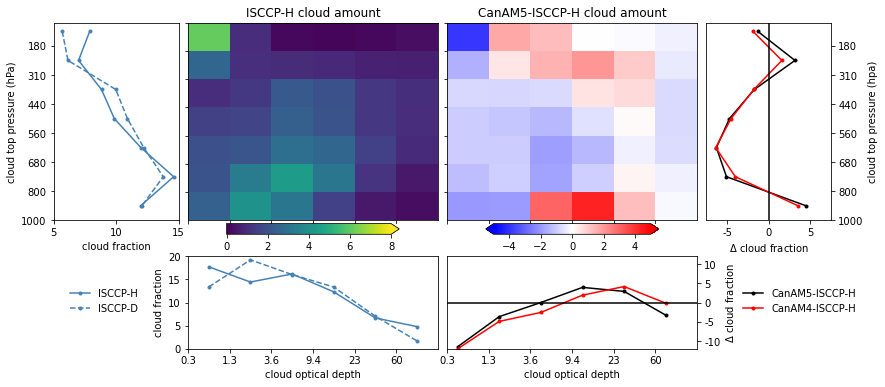

In [12]:
isccp_h_histo=ds_isccp_h_glob_mean['clisccp']
isccp_d_histo=ds_isccp_d_glob_mean['clisccp']
canesm2_histo=ds_canesm2_glob_mean['clisccp'].sel(tau=slice(0.6,2000)).reindex(plev=list(reversed(ds_canesm2_glob_mean['plev'])))
canesm5_histo=ds_canesm5_glob_mean['clisccp'].sel(tau=slice(0.6,2000)).reindex(plev=list(reversed(ds_canesm5_glob_mean['plev'])))

# Compute sums along axes
canesm2_fn_pres=canesm2_histo.sum(['tau'])
canesm5_fn_pres=canesm5_histo.sum(['tau'])
isccp_h_fn_pres=isccp_h_histo.sum(['tau'])
isccp_d_fn_pres=isccp_d_histo.sum(['tau'])

canesm2_fn_tau=canesm2_histo.sum(['plev'])
canesm5_fn_tau=canesm5_histo.sum(['plev'])
isccp_h_fn_tau=isccp_h_histo.sum(['plev'])
isccp_d_fn_tau=isccp_d_histo.sum(['plev'])

# Compute differences
canesm2_histo_diff = canesm2_histo.data-isccp_h_histo.data
canesm5_histo_diff = canesm5_histo.data-isccp_h_histo.data
canesm2_fn_pres_diff = canesm2_fn_pres.data-isccp_h_fn_pres.data
canesm5_fn_pres_diff = canesm5_fn_pres.data-isccp_h_fn_pres.data
canesm2_fn_tau_diff = canesm2_fn_tau.data-isccp_h_fn_tau.data
canesm5_fn_tau_diff = canesm5_fn_tau.data-isccp_h_fn_tau.data

# Layout the axes
fig = py.figure(constrained_layout=False,figsize=[12,6])
widths=[1,2,2,1]
heights=[2,1]
gs1 = fig.add_gridspec(2,4,width_ratios=widths,
                           height_ratios=heights,left=0.05, right=0.95, wspace=0.05)
f_ax1 = fig.add_subplot(gs1[0,0])
f_ax2 = fig.add_subplot(gs1[0,1])
f_ax3 = fig.add_subplot(gs1[0,2])
f_ax4 = fig.add_subplot(gs1[0,3])

gs2 = fig.add_gridspec(2,4,width_ratios=widths,
                           height_ratios=heights,left=0.05, right=0.95, wspace=0.05,hspace=0.35)
f_ax5 = fig.add_subplot(gs2[1,1])
f_ax6 = fig.add_subplot(gs2[1,2])

###################################
# Make the plots
###################################

# Histograms
f2=f_ax2.pcolormesh(isccp_h_histo.transpose(),vmin=0.0,vmax=8.0,cmap='viridis')
cax = py.axes([0.25, 0.39, 0.2, 0.025])
py.colorbar(f2,cax=cax,orientation='horizontal',extend='max')
[a,b] = f_ax2.get_ylim()
f_ax2.set_ylim(b,a)
f_ax2.set_xticks([0,1,2,3,4,5])
f_ax2.set_xticklabels([])
f_ax2.set_yticks([0,1,2,3,4,5,6])
f_ax2.set_yticklabels([])
f_ax2.set_title("ISCCP-H cloud amount")

f3=f_ax3.pcolormesh(canesm5_histo_diff.transpose(),vmin=-5,vmax=5,cmap='bwr')
cax = py.axes([0.55, 0.39, 0.2, 0.025])
py.colorbar(f3,cax=cax,orientation='horizontal',extend='both')
[a,b] = f_ax3.get_ylim()
f_ax3.set_ylim(b,a)
f_ax3.set_xticks([0,1,2,3,4,5])
f_ax3.set_xticklabels([])
f_ax3.set_yticks([0,1,2,3,4,5,6])
f_ax3.set_yticklabels([])
f_ax3.set_title("CanAM5-ISCCP-H cloud amount")

y1=[0.5,1.5,2.5,3.5,4.5,5.5,6.5]
y1=[6.5,5.5,4.5,3.5,2.5,1.5,0.5]
p_data=isccp_h_fn_pres
f_ax1.plot(p_data,y1,color='steelblue',marker='.',label="ISCCP-H")
p_data=isccp_d_fn_pres
f_ax1.plot(p_data,y1,color='steelblue',linestyle="--",marker='.',label="ISCCP-D")

f_ax1.set_xlim(5,15)
f_ax1.set_xticks([5,10,15])
f_ax1.set_xticklabels(['5','10','15'])
f_ax1.set_xlabel("cloud fraction")
f_ax1.set_yticks([0,1,2,3,4,5,6])
f_ax1.set_yticklabels(['1000','800','680','560','440','310','180'])
f_ax1.set_ylabel('cloud top pressure (hPa)')

f_ax1.legend(bbox_to_anchor=(0.75, -0.3),frameon=False)

y1=[6.5,5.5,4.5,3.5,2.5,1.5,0.5]
p_data=canesm5_fn_pres_diff
f_ax4.plot(p_data,y1,color='k',marker='.')
p_data=canesm2_fn_pres_diff
f_ax4.plot(p_data,y1,color='r',marker='.')

f_ax4.axvline(color='black')
f_ax4.yaxis.tick_right()
f_ax4.yaxis.set_label_position("right")
f_ax4.set_xlim(-7.5,7.5)
f_ax4.set_xticks([-5,0,5])
f_ax4.set_xticklabels(['-5','0','5'])
f_ax4.set_xlabel(r"$\Delta$ cloud fraction")
f_ax4.set_yticks([0,1,2,3,4,5,6])
f_ax4.set_yticklabels(['1000','800','680','560','440','310','180'])
f_ax4.set_ylabel('cloud top pressure (hpa)')

x1=[0.5,1.5,2.5,3.5,4.5,5.5]
p_data=isccp_h_fn_tau
f_ax5.plot(x1,p_data,color='steelblue',marker='.')
p_data=isccp_d_fn_tau
f_ax5.plot(x1,p_data,color='steelblue',linestyle="--",marker='.')

f_ax5.set_ylim(0,20)
f_ax5.set_xlim(0,6)
f_ax5.set_xticks([0,1,2,3,4,5])
f_ax5.set_xticklabels(['0.3','1.3','3.6','9.4','23','60'])
f_ax5.set_yticks([0,5,10,15,20])
f_ax5.set_yticklabels(['0','5','10','15','20'])
f_ax5.set_ylabel(r"cloud fraction")
f_ax5.set_xlabel(r"cloud optical depth")

x1=[0.25,1.25,2.25,3.25,4.25,5.25]
p_data=canesm5_fn_tau_diff
f_ax6.plot(x1,p_data,color='k',marker='.',label="CanAM5-ISCCP-H")
p_data=canesm2_fn_tau_diff
f_ax6.plot(x1,p_data,color='r',marker='.',label="CanAM4-ISCCP-H")

f_ax6.axhline(color='black')
f_ax6.set_xticks([0,1,2,3,4,5])
f_ax6.set_xticklabels(['0.3','1.3','3.6','9.4','23','60'])
f_ax6.set_ylim(-12,12)
f_ax6.set_xlim(0,6)
f_ax6.yaxis.tick_right()
f_ax6.yaxis.set_label_position("right")
f_ax6.set_yticks([-10,-5,0,5,10])
f_ax6.set_yticklabels(['-10','-5','0','5','10'])
f_ax6.set_xlabel(r"cloud optical depth")
f_ax6.set_ylabel(r"$\Delta$ cloud fraction")
f_ax6.legend(bbox_to_anchor=(1.15, 0.75),frameon=False)
